In [3]:
import os
import matplotlib.pyplot as plt
from backtests import fetch_portfolio_states, start_backtest, wait_for_backtest, BacktestRequest
from strategy import get_strategy_names, get_strategy_parameters

In [4]:
def plot_portfolio_value(assets_states, save_name=None):
    portfolio_values = [state.assets.equityValue for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    if save_name is not None:
        os.makedirs("plots", exist_ok=True)
        plt.savefig(f"plots/{save_name}.png", transparent=True)
    
    plt.show()

In [5]:
def plot_num_of_positions(assets_states):
    portfolio_values = [len(state.assets.positions) for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Positions')
    plt.show()

In [6]:
class Investment:
    def __init__(self, symbol, start, end, entry, exit_value):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.entry = entry
        self.exit_value = exit_value
        
    @staticmethod
    def from_position(position, start, end):
        return Investment(position.symbol, start, end, position.averageEntryPrice * position.quantity, position.marketValue)

def get_investments(assets_states):    
    def get_last_positions(assets_states):
        result = []
        for before, after in zip(assets_states[:-1], assets_states[1:]):
            today = before.createdAt.date()
            for position in before.assets.positions:
                
                if position.symbol in [p.symbol for p in after.assets.positions]:
                    continue
                    
                result.append((position, today))
                
        for position in assets_states[-1].assets.positions:
            result.append((position, assets_states[-1].createdAt.date()))
                
        return result

    def get_open_dates(assets_states):
        result = dict()
        for before, after in zip(assets_states[:-1], assets_states[1:]):
            today = before.createdAt.date()
            for position in after.assets.positions:

                if position.symbol in [p.symbol for p in before.assets.positions]:
                    continue

                if position.symbol not in result:
                    result[position.symbol] = []

                result[position.symbol].append(today)

        return result
        
    open_dates = get_open_dates(assets_states)
    last_positions = get_last_positions(assets_states)
    
    return list(sorted([
        Investment.from_position(last, [v for v in open_dates[last.symbol] if v < end][-1], end) for last, end in last_positions
    ], key=lambda i: i.exit_value / i.entry, reverse=True))

def print_investments(investments):
    for inv in investments:
        print(f"{inv.symbol}: {inv.exit_value / inv.entry} ({inv.start} to {inv.end})")

In [7]:
def analyze_backtest(backtest_id, name=None):
    portfolio_states = fetch_portfolio_states(backtest_id)
    investments = get_investments(portfolio_states)
    test_return = portfolio_states[-1].assets.equityValue / portfolio_states[0].assets.equityValue - 1
    
    if name is None:
        name = backtest_id
    
    print(f"-> BACKTEST {name}")
    print(f"\tReturn:                     {(test_return*100):.3f}%")
    print(f"\tInvestments:                {len(investments)}")
    print(f"\t Avg investment length:     {(sum((inv.end - inv.start).days for inv in investments) / len(investments)):.3f}")
    print(f"\t Positive investment ratio: {(len([i for i in investments if i.exit_value / i.entry > 1]) / len(investments) * 100):.2f}%")
    
    plot_portfolio_value(portfolio_states, save_name=f"{name}_returns_chart")

In [11]:
def run_backtests_for_all_strategies(symbols, skip, prediction_error):
    def make_request(name):
        return BacktestRequest(
            strategy=name,
            symbols=symbols,
            skip=skip,
            use_predictor=False,
            avg_prediction_error=prediction_error
        )
    
    for strategy_name in get_strategy_names():
        backtest_id = start_backtest(make_request(strategy_name))
        wait_for_backtest(backtest_id)
        analyze_backtest(backtest_id, name=f"err_{(prediction_error*100):.2f}_{strategy_name.lower().replace(' strategy', '').replace(' ', '_')}")

In [10]:
request = BacktestRequest(
    strategy="Basic strategy",
    symbols=500,
    skip=0,
    use_predictor=False,
    avg_prediction_error=0.025
)

backtest_id = start_backtest(request)

In [ ]:
wait_for_backtest(backtest_id)

In [13]:
portfolio_states = fetch_portfolio_states(backtest_id)

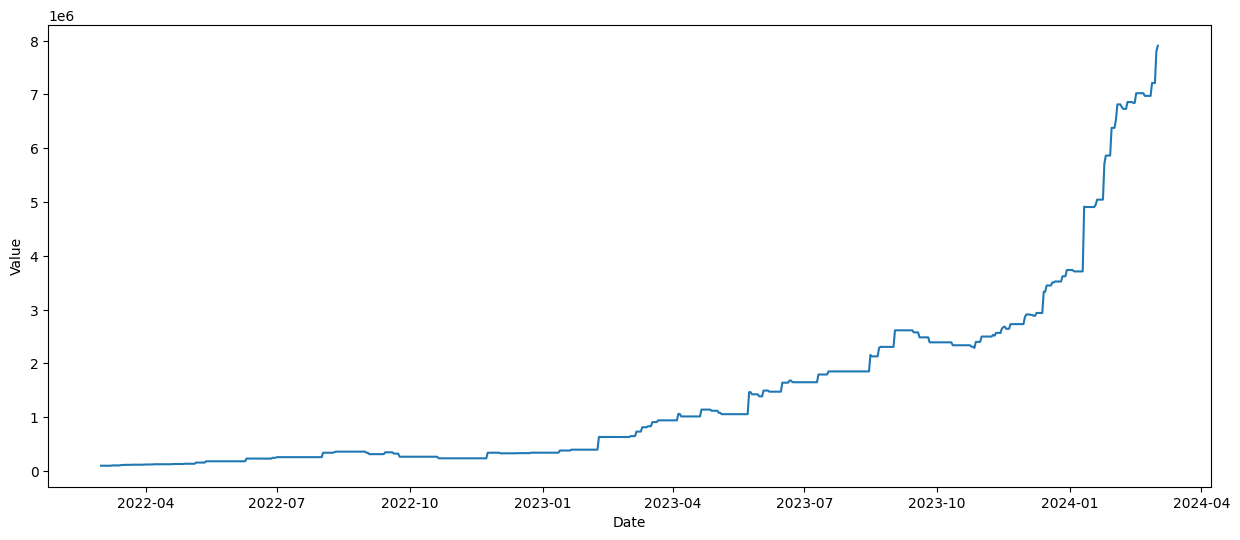

In [14]:
plot_portfolio_value(portfolio_states)

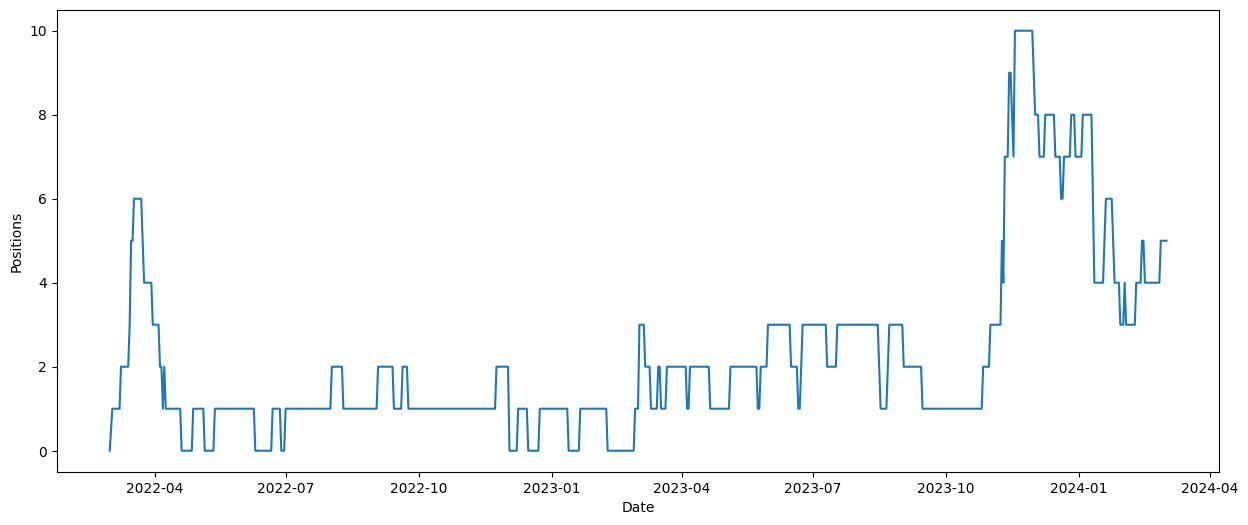

In [15]:
plot_num_of_positions(portfolio_states)

In [24]:
investments = get_investments(portfolio_states)

Tests:

1. All strategies, default params, 0% error
2. All strategies, default params, 2.5% error
3. Averaged 3-fold (2k, 1.8k skip) tests

Results:

1. Return
2. Number of investments (number of trading actions?)
3. Positive investment ratio
4. Avg investment length
5. Return plot

Waiting for backtest e8c8f9d0-eac1-4c76-9186-632a3111d8fd
-> BACKTEST err_5.00_basic
	Return:                     6695.706%
	Investments:                28
	 Avg investment length:     55.607
	 Positive investment ratio: 78.57%


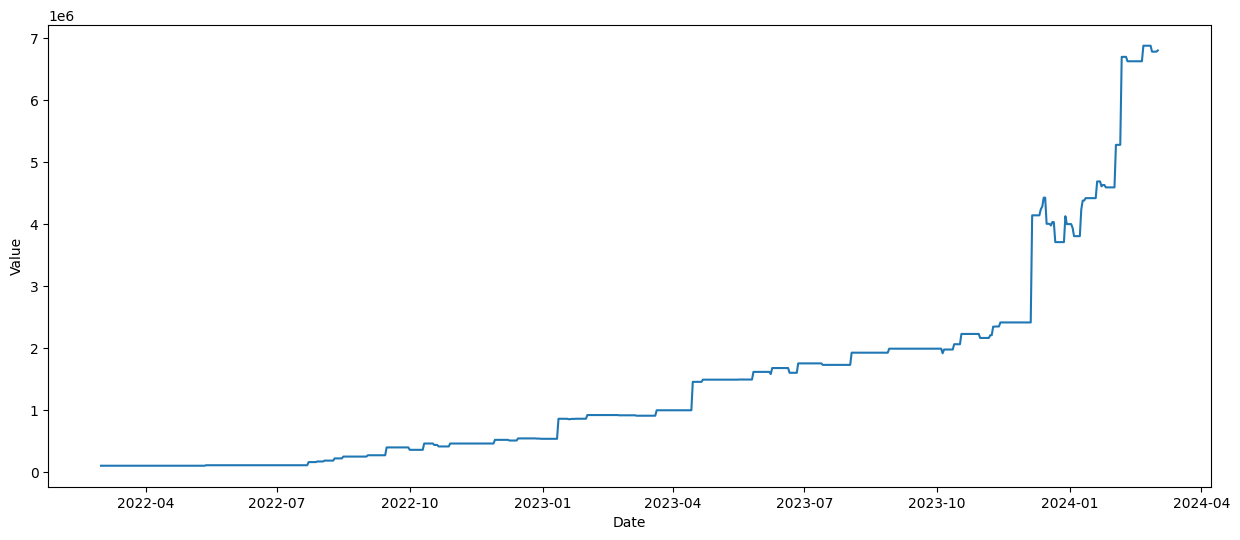

Waiting for backtest 9ff5f696-1bed-47ae-91a3-e6dea164baae
-> BACKTEST err_5.00_greedy_optimal
	Return:                     733.087%
	Investments:                11
	 Avg investment length:     39.818
	 Positive investment ratio: 100.00%


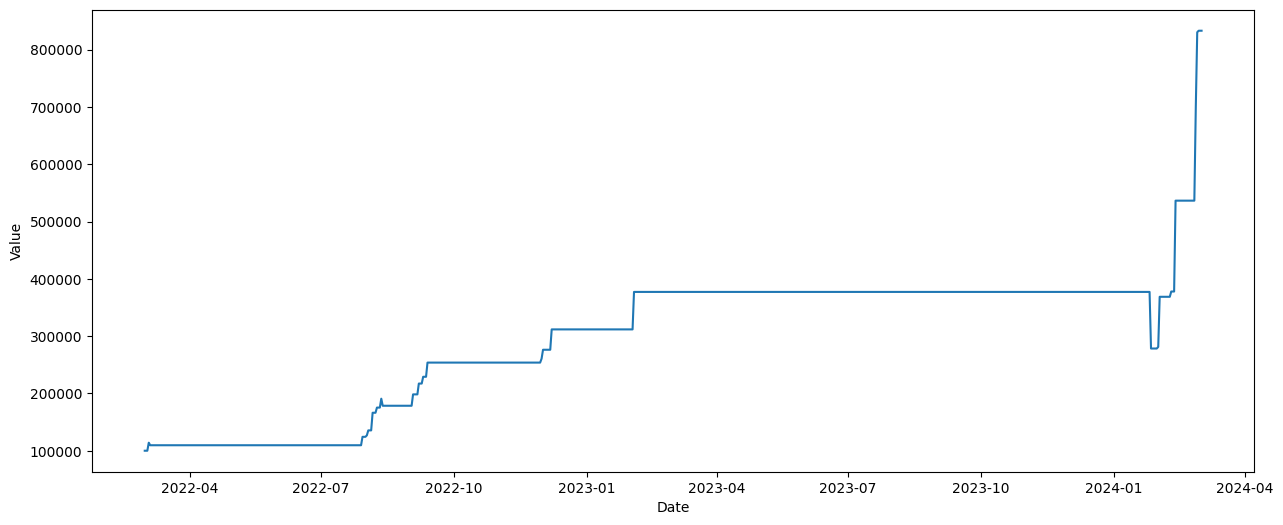

Waiting for backtest 3c1aa070-5a80-45be-80fa-00493085d261
-> BACKTEST err_5.00_overreaction
	Return:                     17.026%
	Investments:                516
	 Avg investment length:     35.527
	 Positive investment ratio: 41.28%


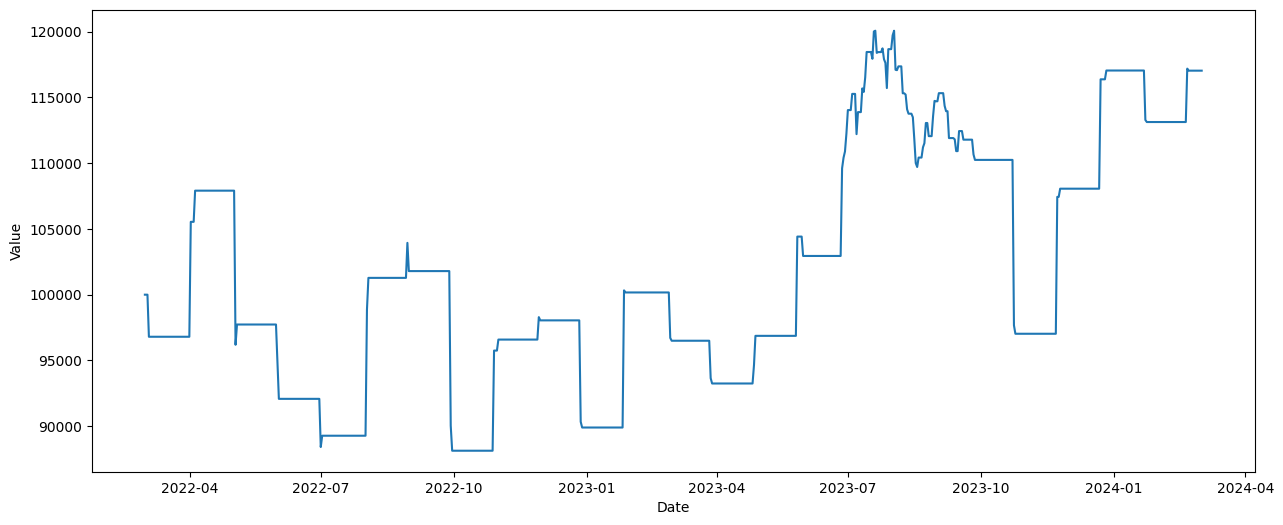

Waiting for backtest 24653af7-d646-40c3-a260-a200fbc77f1a
-> BACKTEST err_5.00_overreaction_with_predictions
	Return:                     -5.196%
	Investments:                524
	 Avg investment length:     34.015
	 Positive investment ratio: 35.11%


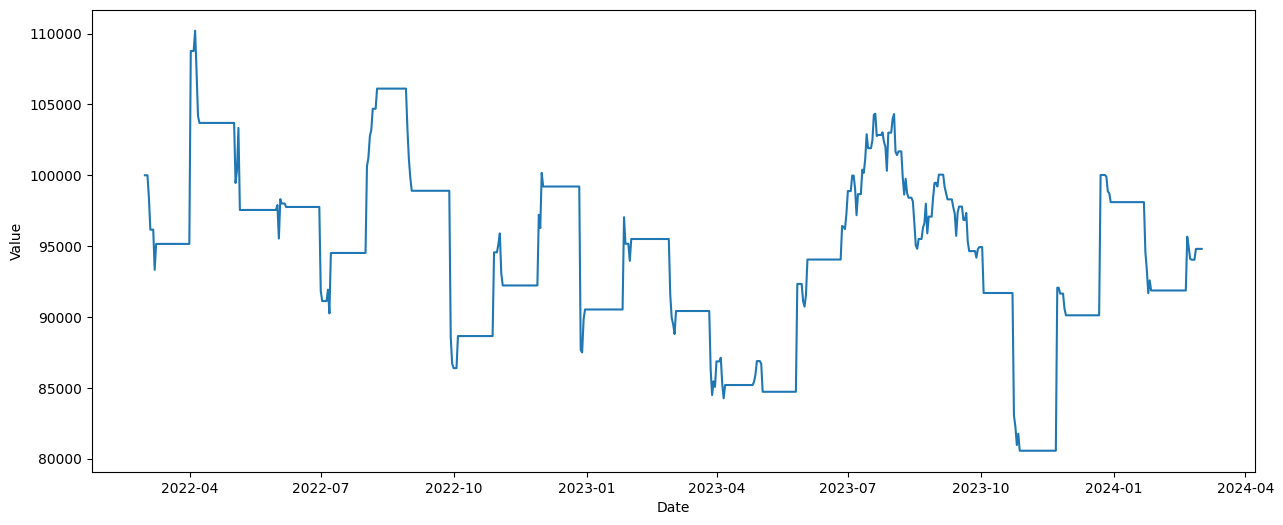

Waiting for backtest 26414edc-a686-433a-81f6-ae1d3de20899
-> BACKTEST err_5.00_trend_following
	Return:                     2.511%
	Investments:                112
	 Avg investment length:     474.009
	 Positive investment ratio: 59.82%


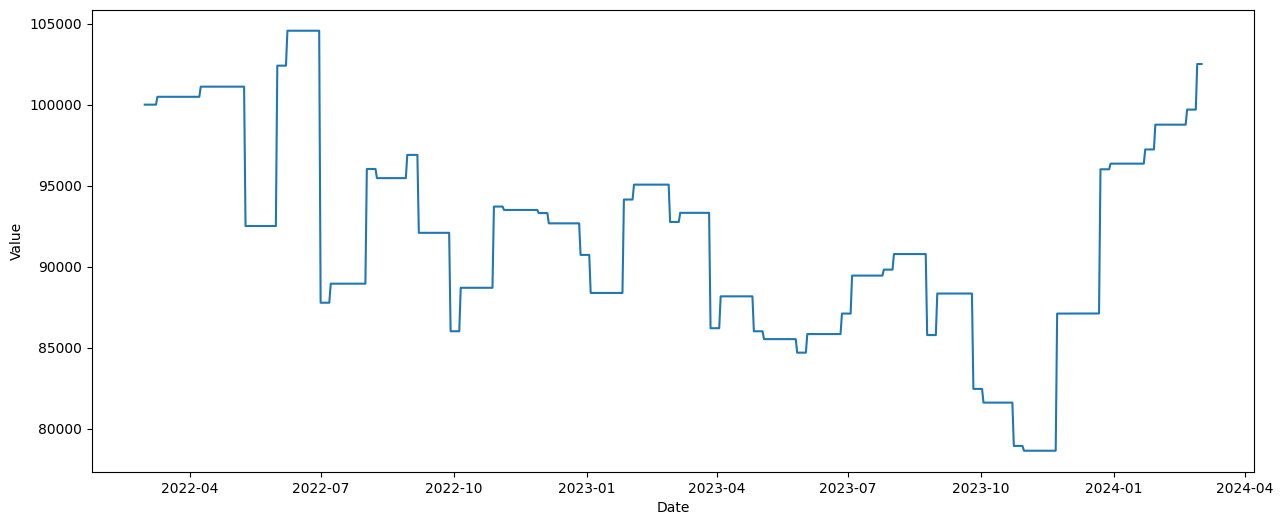

Waiting for backtest 580f809d-0c69-478c-bfd4-8935bada4fab
-> BACKTEST err_5.00_trend_following_with_predictions
	Return:                     -13.743%
	Investments:                158
	 Avg investment length:     156.190
	 Positive investment ratio: 36.71%


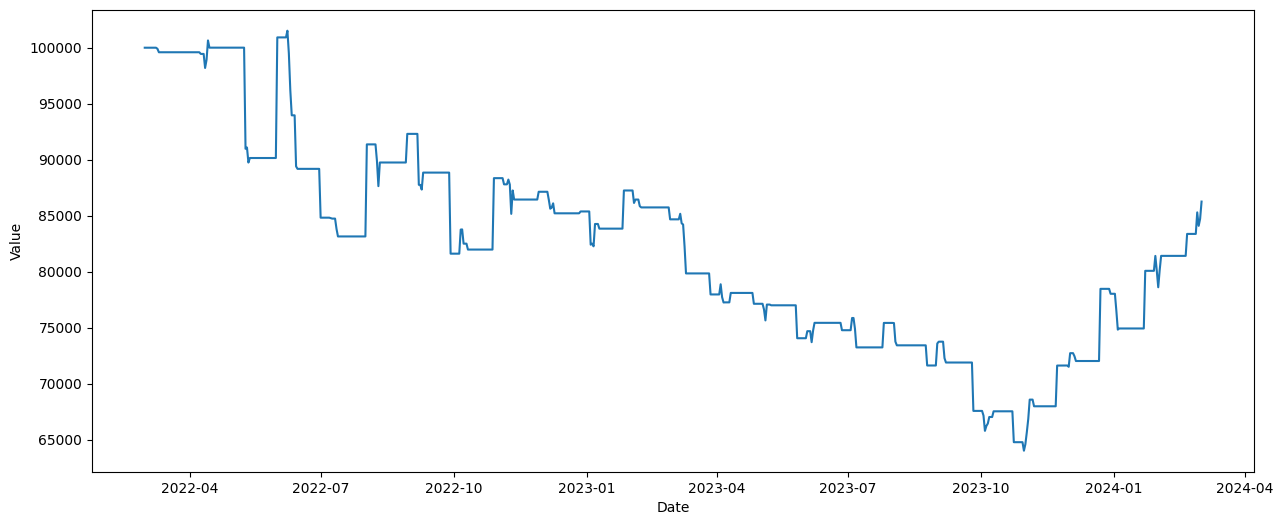

Waiting for backtest e8b46a0d-06e6-40c5-9ebe-611a137bad43
-> BACKTEST err_5.00_pca
	Return:                     64.248%
	Investments:                2323
	 Avg investment length:     10.867
	 Positive investment ratio: 60.44%


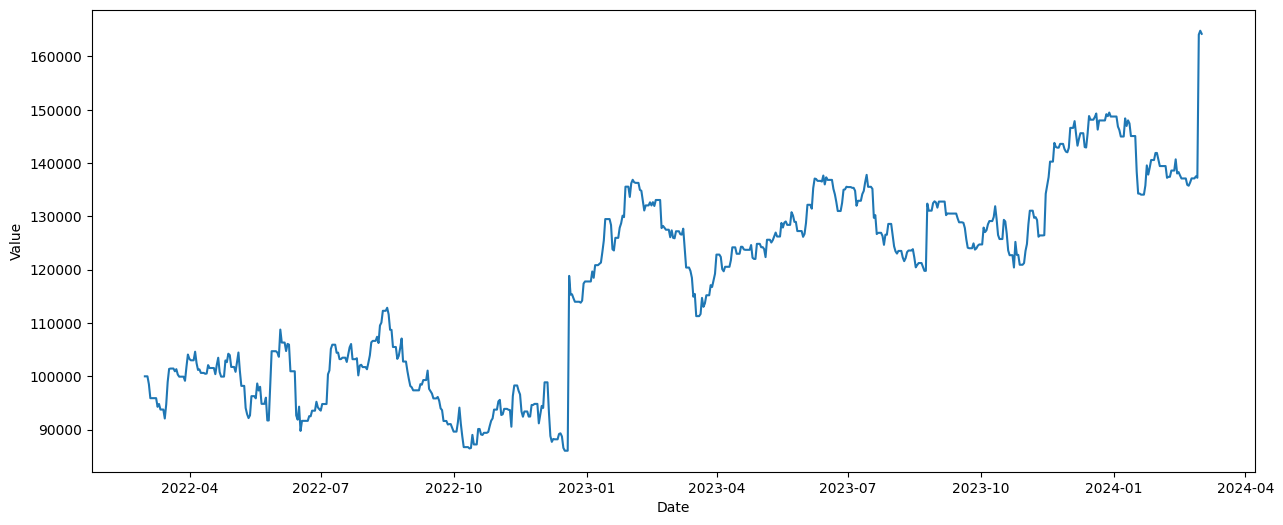

Waiting for backtest 6bdef291-c741-480a-8529-a2f836a41184
-> BACKTEST err_5.00_pca_with_predictions
	Return:                     -65.986%
	Investments:                1562
	 Avg investment length:     11.766
	 Positive investment ratio: 39.44%


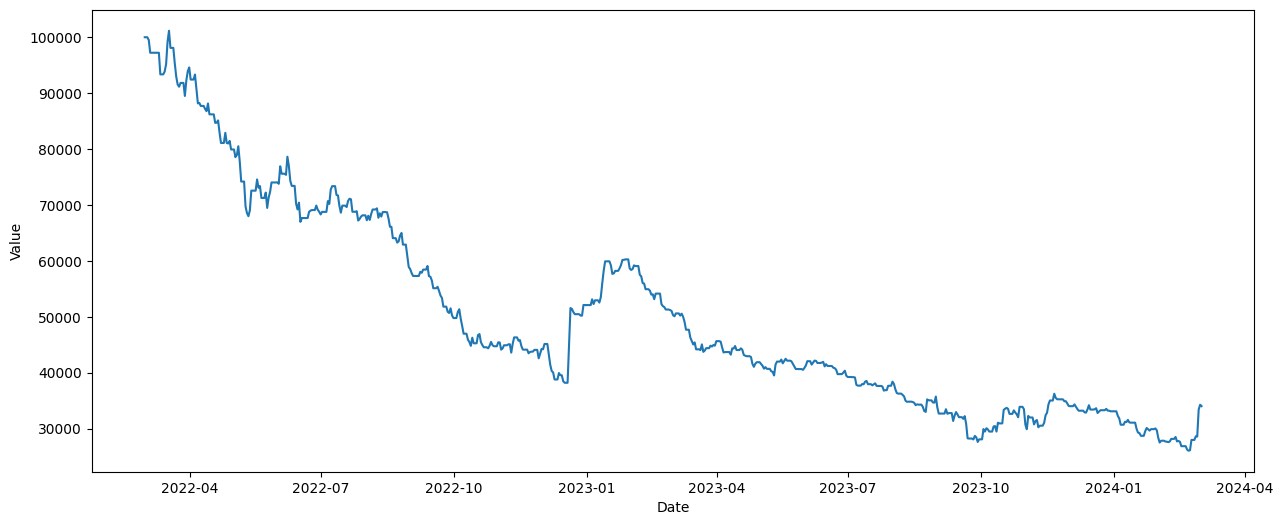

In [12]:
run_backtests_for_all_strategies(symbols=300, skip=200, prediction_error=0.05)